In [23]:
from data.cifar10 import CIFAR10DataModule
import torch
import pytorch_lightning as pl
import torchvision
import torch.nn.functional as F
from rejectron.pqmodule import PQModule
import torchmetrics
import pandas as pd
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt

In [4]:
class Model(pl.LightningModule):
    def __init__(self, n_test):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = torch.nn.Linear(512, 2)
        self.weights = torch.nn.Parameter(data=torch.tensor([10 / n_test, 1.]), requires_grad=False)
        self.corr = torch.nn.Parameter(data=torch.tensor([-.1, .1]), requires_grad=False)
        self.cnf = torchmetrics.ConfusionMatrix(2)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y[y >= 0] = 1
        y[y < 0] = 0

        y_hat = self(x) + self.corr
        loss = F.cross_entropy(y_hat, y, weight=self.weights)
        self.cnf.update(y_hat.argmax(-1), y)
        return {'loss': loss}

    def on_train_epoch_end(self, **kwargs):
        cnf = self.cnf.compute()
        print(f"""Confusion matrix:
{cnf[0, 0]} | {cnf[0, 1]}\n{cnf[1, 0]} | {cnf[1, 1]}\n""")
        self.cnf.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.001)

In [8]:
pq = PQModule(datamodule=CIFAR10DataModule(shift=False, test_samples=10), batch_size=1024, num_workers=16)

In [6]:
model = Model(n_test=pq.n_test)

In [9]:
trainer = pl.Trainer(gpus=[1], max_epochs=10)
trainer.fit(model, pq.train_dataloader())

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type            | Params
------------------------------------------
0 | model | ResNet          | 11.2 M
1 | cnf   | ConfusionMatrix | 0     
------------------------------------------
11.2 M    Trainable params
4         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (49) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Confusion matrix:

0 | 10
0 | 50000
Confusion matrix:

0 | 10
0 | 50000
Confusion matrix:

0 | 10
0 | 50000
Confusion matrix:

0 | 10
0 | 50000
Confusion matrix:

0 | 10
0 | 50000
Confusion matrix:

0 | 10
0 | 50000
Confusion matrix:

0 | 10
0 | 50000
Confusion matrix:

0 | 10
0 | 50000
Confusion matrix:

0 | 10
0 | 50000
Confusion matrix:

0 | 10
0 | 50000


In [19]:
def get_exp(samples, shift, dataset='cifar', method='detectron'):
    r = []
    for file in glob(
            f'/voyager/projects/tomginsberg/detectron/checkpoints/{dataset}/{method}/samples={samples}*_shift={shift}.csv'):
        r.append(pd.read_csv(file))
    return pd.concat(r).reset_index(drop=True)

In [20]:
data =

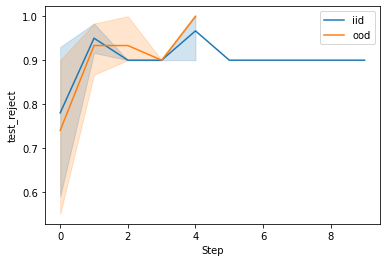

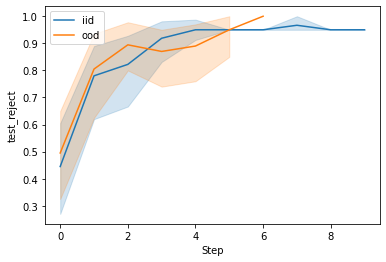

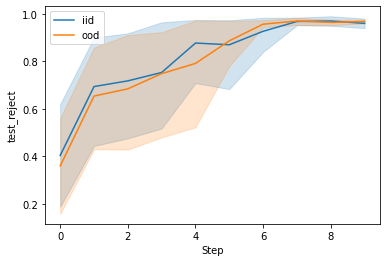

In [24]:
for samples in [10,20,50]:
    for shift in [False, True]:
        data = get_exp(samples=samples, shift=shift, dataset='cifar', method='domain')
        sns.lineplot(x='Step', y='test_reject', data=data, label=f'ood' if shift else f'iid')
    plt.show()